CREATE FILE PATH

In [402]:
import os
import time
import uuid

In [403]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

CHECK THAT ALL PHYSICAL DEVICES WORK

In [404]:
import tensorflow as tf
import cv2
import xml
import xmltodict
import json
import numpy as np
from matplotlib import pyplot as plt

In [405]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [406]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

LOAD IMAGES INTO TENSORFLOW DATA PIPELINE

In [407]:
images = tf.data.Dataset.list_files('data/*/images/*.jpg')
images.as_numpy_iterator().next()

def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [408]:
images = images.map(load_image)
images.as_numpy_iterator().next()

array([[[ 0,  0,  2],
        [ 5,  5,  7],
        [22, 22, 24],
        ...,
        [65, 74, 81],
        [62, 71, 80],
        [55, 64, 73]],

       [[ 0,  0,  2],
        [ 5,  5,  7],
        [22, 22, 24],
        ...,
        [65, 74, 81],
        [62, 71, 80],
        [55, 64, 73]],

       [[ 0,  0,  2],
        [ 5,  5,  7],
        [22, 22, 24],
        ...,
        [66, 75, 82],
        [63, 72, 81],
        [55, 64, 73]],

       ...,

       [[ 0,  1,  0],
        [ 5,  7,  6],
        [19, 21, 20],
        ...,
        [50, 55, 49],
        [59, 64, 58],
        [62, 67, 61]],

       [[ 0,  2,  1],
        [ 3,  5,  4],
        [16, 18, 17],
        ...,
        [50, 55, 51],
        [58, 63, 57],
        [61, 66, 60]],

       [[ 4,  6,  5],
        [ 3,  5,  4],
        [14, 16, 15],
        ...,
        [48, 53, 49],
        [61, 66, 60],
        [67, 72, 66]]], dtype=uint8)

VIEW RAW IMAGES WITH MATPLOTLIB

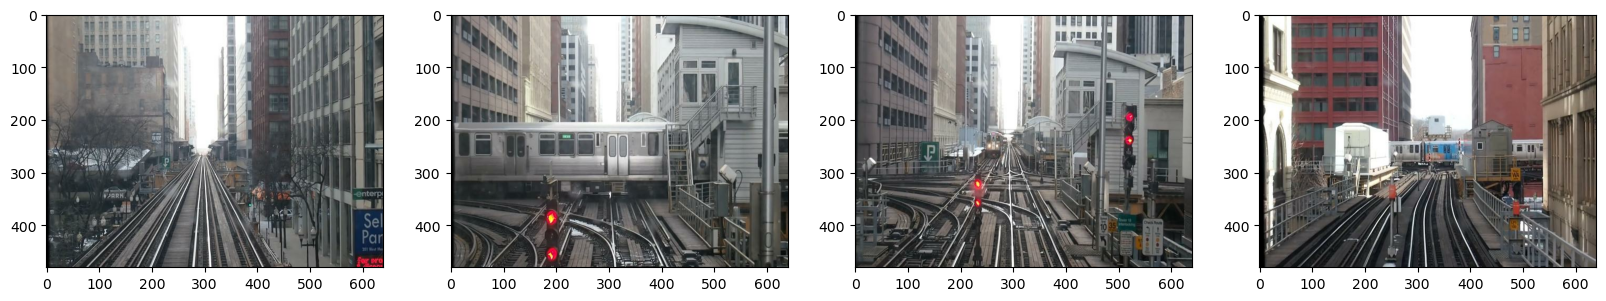

In [409]:
image_generator = images.batch(4).as_numpy_iterator()
plot_images = image_generator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

ALBUMENTATIONS TRANSFORM PIPELINE

In [410]:
import albumentations as alb

In [411]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

TEST ALBUMENTATIONS WITH OPENCV AND JSON

In [412]:
img = cv2.imread(os.path.join('data','train', 'images','youtube-0_jpg.rf.380c3c2f162dcde0d2bb19e8e4f4676f.jpg'))
with open(os.path.join('data', 'train', 'labels', 'youtube-0_jpg.rf.380c3c2f162dcde0d2bb19e8e4f4676f.xml'), 'r') as f:
    label = [xmltodict.parse(f.read())['annotation']]
label[0]['object']['bndbox']

{'xmin': '561', 'xmax': '589', 'ymin': '145', 'ymax': '269'}

EXTRACT COORDINATES

In [413]:
coords = [0, 0, 0, 0]
coords[0] = int(label[0]['object']['bndbox']['xmin'])
coords[1] = int(label[0]['object']['bndbox']['ymin'])
coords[2] = int(label[0]['object']['bndbox']['xmax'])
coords[3] = int(label[0]['object']['bndbox']['ymax'])
coords

[561, 145, 589, 269]

In [414]:
coords = list(np.divide(coords, [640, 480, 640, 480]))
coords

[0.00136962890625,
 0.0006293402777777777,
 0.00143798828125,
 0.0011675347222222222]

APPLY AUGMENTATIONS

In [415]:
augmented = augmentor(image=img, bboxes='coords', class_labels=['signal light'])
augmented['bboxes']

AssertionError: 